In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [3]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### a), b) Changing repressor binding energy

In [2]:
def get_parameters(mean, cov):
	mu = np.log(mean) #- (np.log(cov**2 + 1) / 2)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
							 p_emat, r_emat, ep_wt, er_wt,
							 mean_p, mean_r, cov):
	rng = np.random.default_rng()
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)

	n_p = rng.lognormal(mu_p, sigma_p, 1)[0]
	n_r = rng.lognormal(mu_r, sigma_r, 1)[0]
	
	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

	z = np.zeros(3)
	z[0] = 1
	z[1] = n_p / n_NS * w_p
	z[2] = n_r / n_NS * w_r

	return z[1] / np.sum(z)

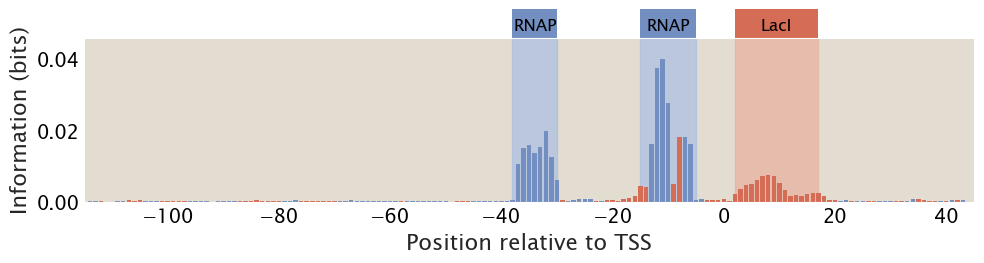

In [10]:
n_NS = len(genome)
n_p = 5000
n_r = 100
ep_wt = -5
er_wt = -12

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   annotate_stn=False)

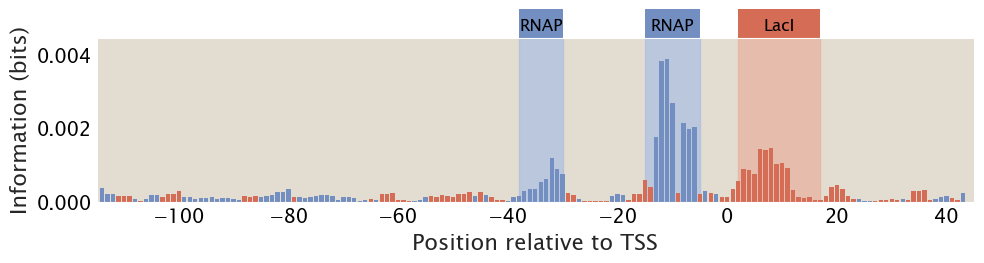

In [11]:
n_NS = len(genome)
ep_wt = -5
er_wt = -12

mean_p = 5000
mean_r = 100
cov = 100

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
						*[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
						  mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   annotate_stn=False)